# Expectation-Maximization Gaussian Mixture  from Scratch

*Necessary Imports*

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

Generate data from a Mixture of Gaussians

In [0]:
def generate_MoG_data(num_data, means, covariances, weights):

    num_clusters = len(weights)
    data = []

    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)

    return data

In [0]:
np.random.seed(4)

init_means = [[5, 0],
              [1, 1],
              [0, 5]]

init_covariances = [[[.5, 0.], [0, .5]],
                    [[.92, .38], [.38, .91]],
                    [[.5, 0.], [0, .5]]]

init_weights = [1/4., 1/2., 1/4.]

data = generate_MoG_data(100, init_means, init_covariances, init_weights)

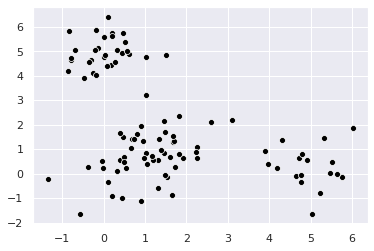

In [5]:
d = np.vstack(data)
sns.scatterplot(d[:,0], d[:,1], color='black')

### Log-Likelihood

In [0]:
def loglikelihood(data, weights, means, covs):

    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        ll += np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))
        
    return ll

### Expectation Maximization Model

 **E-Step:** 
 $ r_{ik} = \dfrac{\pi_k N (x_i | \mu_k, Σ_k)}{\sum_{k=1}^{L}\pi_k N (x_i | \mu_k, Σ_k)} $, estimate cluster responsibility

**M-Step:** 
$ N^{soft}_k = \sum_{i=1}^{N} r_{ik}  $, maximize likelihood


In [0]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration:", i)
                
        # E-step: compute responsibilities
        from scipy.stats import multivariate_normal
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] = weights[k] * multivariate_normal.pdf(data[j], means[k], covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp/row_sums # normalize

        # M-step: Compute the total responsibility assigned to each cluster
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weights   
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += resp[j,k]*data[j]
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                weighted_sum += resp[j,k] * np.outer(data[j] - means[k], data[j] - means[k])
            covariances[k] = weighted_sum/counts[k]          
        
        # Compute the loglikelihood
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration:", i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [8]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration: 0
Iteration: 5
Iteration: 10
Iteration: 15
Iteration: 20
Iteration: 22


In [9]:
print("Weights:", results['weights'])
print("Means:", results['means'])
print("Covariance:", results['covs'])
print("Log-Likelihoods:", results['loglik'])

Weights: [0.3007102300609823, 0.17993710074247007, 0.5193526691965472]
Means: [array([0.02138285, 4.947729  ]), array([4.94239235, 0.31365311]), array([1.08181125, 0.73903508])]
Covariance: [array([[0.2932614 , 0.05048455],
       [0.05048455, 0.35281537]]), array([[ 0.3556437 , -0.01494875],
       [-0.01494875,  0.66695025]]), array([[0.67114992, 0.33058965],
       [0.33058965, 0.90429724]])]
Log-Likelihoods: [-541.3161248036661, -372.1355927865928, -366.99356972063583, -365.65991992885023, -364.33486476974326, -362.879604601724, -361.3750402777832, -359.7842225540679, -357.83486581694126, -354.4429407838179, -347.33757513783434, -338.9500319134904, -336.19269736896905, -333.8130318590334, -329.78761702083597, -323.1580854903375, -319.52041347639175, -319.1101542516828, -318.9110757513651, -318.84375743283243, -318.8321411837265, -318.83092993526367, -318.830829251483, -318.83082148560914]


**Plot**

In [0]:
#from mlab.py
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0):
    Xmu = X-mux
    Ymu = Y-muy
    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [0]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko')

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'blue']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)

Parameters after initialization

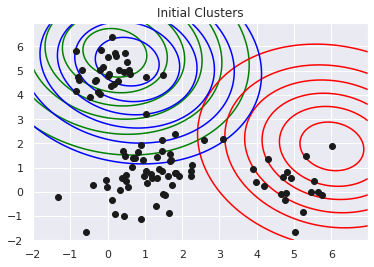

In [12]:
plot_contours(data, initial_means, initial_covs, 'Initial Clusters')

Parameters after running EM to Convergence

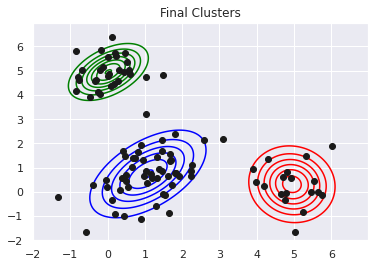

In [13]:
plot_contours(data, results['means'], results['covs'], 'Final Clusters')

Text(0, 0.5, 'Log-likelihood')

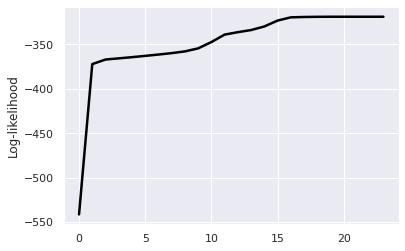

In [14]:
loglikelihoods = results['loglik']
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=2.5, color='black')
plt.ylabel('Log-likelihood')

## Different Clusters

In [0]:
np.random.seed(2000)

init_means = [[2, 4],
              [1, 2],
              [5, 1]]

init_covariances = [[[.5, 0.], [0, .5]],
                    [[.92, .38], [.38, .91]],
                    [[.5, 0.], [0, .5]]]

init_weights = [1/4., 1/2., 1/4.]

data = generate_MoG_data(100, init_means, init_covariances, init_weights)

In [16]:
# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration: 0
Iteration: 5
Iteration: 10
Iteration: 15
Iteration: 20
Iteration: 25
Iteration: 30
Iteration: 35
Iteration: 40
Iteration: 45
Iteration: 50
Iteration: 55
Iteration: 60
Iteration: 65
Iteration: 70
Iteration: 75
Iteration: 77


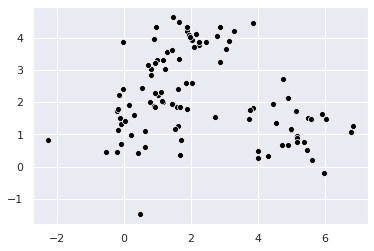

In [17]:
d = np.vstack(data)
sns.scatterplot(d[:,0], d[:,1], color='black')

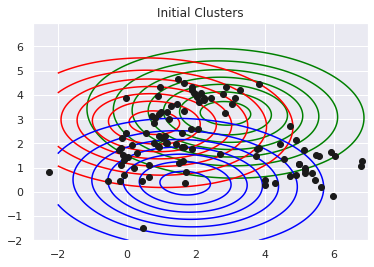

In [18]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial Clusters')

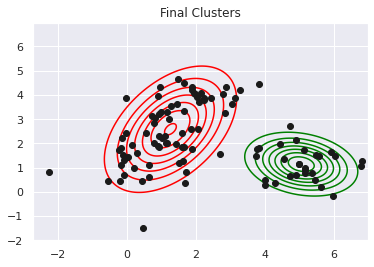

In [19]:
# Parameters after running EM to convergence
# changing init_weights to [1/3., 1/3., 1/3.] will result in 3 clusters
plot_contours(data, results['means'], results['covs'], 'Final Clusters')